In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import functools
from IPython.display import Image, clear_output

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
import tensorflow as tf
import pandas as pd
from datetime import datetime
%matplotlib inline
pd.set_option("display.precision", 2)
tf.random.set_seed(42)

In [2]:
# Tensorflow base model

In [3]:
LABEL_COLUMN = 'total_cases'
NUMERIC_COLUMNS = ['year',
                    'weekofyear',
                    'ndvi_ne',
                    'ndvi_nw',
                    'ndvi_se',
                    'ndvi_sw',
                    'precipitation_amt_mm',
                    'reanalysis_air_temp_k',
                    'reanalysis_avg_temp_k',
                    'reanalysis_dew_point_temp_k',
                    'reanalysis_max_air_temp_k',
                    'reanalysis_min_air_temp_k',
                    'reanalysis_precip_amt_kg_per_m2',
                    'reanalysis_relative_humidity_percent',
                    'reanalysis_sat_precip_amt_mm',
                    'reanalysis_specific_humidity_g_per_kg',
                    'reanalysis_tdtr_k',
                    'station_avg_temp_c',
                    'station_diur_temp_rng_c',
                    'station_max_temp_c',
                    'station_min_temp_c',
                    'station_precip_mm']
CATEGORICAL_COLUMNS = ['city']
CSV_COLUMNS = [LABEL_COLUMN] + CATEGORICAL_COLUMNS + NUMERIC_COLUMNS
CSV_COLUMNS_NO_LABEL = CATEGORICAL_COLUMNS + NUMERIC_COLUMNS
CATEGORIES = {
    'city': ['sj', 'iq']
}

cols_to_norm = ['precipitation_amt_mm',
                    'reanalysis_air_temp_k',
                    'reanalysis_avg_temp_k',
                    'reanalysis_dew_point_temp_k',
                    'reanalysis_max_air_temp_k',
                    'reanalysis_min_air_temp_k',
                    'reanalysis_precip_amt_kg_per_m2',
                    'reanalysis_relative_humidity_percent',
                    'reanalysis_sat_precip_amt_mm',
                    'reanalysis_specific_humidity_g_per_kg',
                    'reanalysis_tdtr_k',
                    'station_avg_temp_c',
                    'station_diur_temp_rng_c',
                    'station_max_temp_c',
                    'station_min_temp_c',
                    'station_precip_mm']
cols_to_scale = ['year',
                    'weekofyear']

TRAIN_DATASET_FRAC = 0.8
train_file = 'dengue_features_train_1.csv'
test_file = 'dengue_features_test.csv'

In [4]:
#Get training dataset

def extract_data(train_file, columns):
    all_data = pd.read_csv(train_file, usecols = columns)
    # map categorical to columns
    for feature_name in CATEGORICAL_COLUMNS:
        mapping_dict = { CATEGORIES[feature_name][i] : CATEGORIES[feature_name][i] for i in range(0, len(CATEGORIES[feature_name]) ) }
        all_data[feature_name] = all_data[feature_name].map(mapping_dict)
    
    all_data = pd.get_dummies(all_data, prefix='', prefix_sep='')
    all_data = all_data.interpolate(method ='linear', limit_direction ='forward')
    
    return all_data

all_data = extract_data(train_file, CSV_COLUMNS)

# Split data into train and test
train_data = all_data.sample(frac=TRAIN_DATASET_FRAC,random_state=0)
test_data = all_data.drop(train_data.index)

train_y = train_data.pop(LABEL_COLUMN)
test_y = test_data.pop(LABEL_COLUMN)

# Display one batch from dataset
train_data.head()

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,...,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,iq,sj
511,2000,8,0.18,0.21,0.15,0.15,7.67,297.09,297.22,292.17,...,7.67,13.67,1.99,24.77,6.63,28.3,20.6,3.8,0,1
961,2000,51,0.27,0.17,0.23,0.30,3.90,300.41,302.00,291.09,...,3.90,13.19,13.00,28.20,12.28,35.0,21.0,0.0,1,0
231,1994,40,0.10,0.07,0.12,0.19,0.63,300.38,300.50,295.36,...,0.63,16.74,2.63,28.71,6.90,34.4,24.4,8.2,0,1
687,2003,29,-0.06,-0.11,0.22,0.19,62.57,300.15,300.34,296.32,...,62.57,17.72,1.91,27.47,5.89,31.7,21.7,43.0,0,1
34,1990,52,0.30,0.28,0.17,0.16,0.00,298.04,298.09,292.11,...,0.00,13.68,2.29,25.16,5.84,28.9,21.1,20.9,0,1


In [5]:
train_stats = all_data.describe()
train_stats.pop(LABEL_COLUMN)
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
year,1456.0,2001.03,5.41,1990.00,1997.00,2002.00,2005.00,2010.00
weekofyear,1456.0,26.50,15.02,1.00,13.75,26.50,39.25,53.00
ndvi_ne,1456.0,0.13,0.14,-0.41,0.04,0.12,0.23,0.51
ndvi_nw,1456.0,0.13,0.12,-0.46,0.05,0.12,0.21,0.45
ndvi_se,1456.0,0.20,0.07,-0.02,0.15,0.20,0.25,0.54
ndvi_sw,1456.0,0.20,0.08,-0.06,0.14,0.19,0.25,0.55
precipitation_amt_mm,1456.0,45.70,43.65,0.00,9.79,38.32,70.23,390.60
reanalysis_air_temp_k,1456.0,298.70,1.36,294.64,297.66,298.64,299.83,302.20
reanalysis_avg_temp_k,1456.0,299.22,1.26,294.89,298.26,299.29,300.21,302.93
reanalysis_dew_point_temp_k,1456.0,295.24,1.53,289.64,294.12,295.64,296.46,298.45


In [6]:
def preproc_data(data):
    new_data = data.copy()
    # Normalize temp and percipation
    new_data[cols_to_norm] = StandardScaler().fit_transform(new_data[cols_to_norm])

    # Scale year and week no but within (0,1)
    new_data[cols_to_scale] = MinMaxScaler(feature_range=(0, 1)).fit_transform(new_data[cols_to_scale])
    
    return new_data

train_data = preproc_data(train_data)
all_y = all_data.pop(LABEL_COLUMN)
all_data = preproc_data(all_data)

test_data = preproc_data(test_data)

# Descrive normalized data
train_stats = train_data.describe()
train_stats = train_stats.transpose()
train_data.head()

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,...,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,iq,sj
511,0.50,0.13,0.18,0.21,0.15,0.15,-0.91,-1.19,-1.60,-1.99,...,-0.91,-1.97,-0.83,-1.89,-0.69,-2.10,-0.97,-0.80,0,1
961,0.50,0.96,0.27,0.17,0.23,0.30,-1.00,1.27,2.22,-2.70,...,-1.00,-2.28,2.26,0.79,1.94,1.29,-0.71,-0.89,1,0
231,0.20,0.75,0.10,0.07,0.12,0.19,-1.08,1.25,1.02,0.09,...,-1.08,0.01,-0.65,1.19,-0.57,0.98,1.49,-0.69,0,1
687,0.65,0.54,-0.06,-0.11,0.22,0.19,0.46,1.08,0.90,0.71,...,0.46,0.64,-0.85,0.22,-1.04,-0.38,-0.26,0.14,0,1
34,0.00,0.98,0.30,0.28,0.17,0.16,-1.10,-0.49,-0.91,-2.03,...,-1.10,-1.97,-0.74,-1.58,-1.06,-1.80,-0.65,-0.39,0,1


In [7]:
# Build network with 
def build_model():
  model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=[len(train_data.keys())]),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, amsgrad=False)

  model.compile(loss='mae',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

model = build_model()

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1600      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,825
Trainable params: 5,825
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Train the Model.
EPOCHS = 100

# The patience parameter is the amount of epochs to check for improvement
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(
  all_data, all_y,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
                    callbacks=[early_stop])

In [10]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
34,16.53,16.53,1808.03,7.36,7.36,191.12,34
35,16.99,16.99,1772.56,7.60,7.60,198.75,35
36,16.73,16.73,1779.72,7.43,7.43,189.54,36
37,16.39,16.39,1749.16,7.15,7.15,187.53,37
38,16.21,16.21,1739.83,7.30,7.30,188.83,38


In [11]:
loss, mae, mse = model.evaluate(test_data, test_y, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} Total_cases".format(mae))

10/10 - 0s - loss: 14.6933 - mae: 14.6933 - mse: 1709.4595 - 25ms/epoch - 3ms/step
Testing set Mean Abs Error: 14.69 Total_cases


10/10 [==============================] - 0s 1ms/step


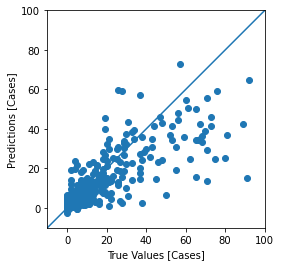

In [12]:
test_predictions = model.predict(test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_y, test_predictions)
plt.xlabel('True Values [Cases]')
plt.ylabel('Predictions [Cases]')
lims = [-10, 100]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [13]:
# Get Test file and preprocess test data

org_test_data = extract_data(test_file, CSV_COLUMNS_NO_LABEL)
proc_test_data = preproc_data(org_test_data)

In [14]:
test_predictions = model.predict(proc_test_data).flatten()
org_test_data = pd.read_csv(test_file)
org_test_data['total_cases'] = test_predictions
org_test_data['total_cases'] = org_test_data['total_cases'].apply(lambda x: int(x) if x > 0 else 0)
org_test_data[['city', 'year', 'weekofyear', 'total_cases']]

13/13 [==============================] - 0s 1ms/step


,city,year,weekofyear,total_cases
0,sj,2008,18,27
1,sj,2008,19,26
2,sj,2008,20,13
3,sj,2008,21,61
4,sj,2008,22,29
...,...,...,...,...
411,iq,2013,22,1
412,iq,2013,23,1
413,iq,2013,24,0
414,iq,2013,25,2


In [15]:
#org_test_data[['city', 'year', 'weekofyear', 'total_cases']].to_csv('C:/Users/tessy/Desktop/Notes/SEM II/ML1/Project/out.csv', index=False)

In [16]:
#as you can see the MAE is 14

In [17]:
from data_info import *
from preprocessing_helpers import *

In [18]:
new_iq_norm = [
    'reanalysis_air_temp_k',
    'reanalysis_avg_temp_k',
    'reanalysis_dew_point_temp_k',
    'reanalysis_max_air_temp_k',
    'reanalysis_min_air_temp_k',
    'reanalysis_specific_humidity_g_per_kg',
    'station_max_temp_c',
    'station_min_temp_c'
]
new_iq_scale = [
                 'weekofyear',
                 'year',
]

extra_iq_cols = [
]
new_sj_norm = [
                'reanalysis_dew_point_temp_k',
                'reanalysis_min_air_temp_k',
                'reanalysis_relative_humidity_percent',
                'reanalysis_specific_humidity_g_per_kg',
]
new_sj_scale = [
                 'weekofyear',
                 'year',
]

extra_sj_cols = [
]
new_iq_cols = [LABEL_COLUMN] + CATEGORICAL_COLUMNS + new_iq_norm + new_iq_scale + extra_iq_cols + [DATETIME_COLUMN]
new_iq_cols_no_label = CATEGORICAL_COLUMNS + new_iq_norm + new_iq_scale + extra_iq_cols + [DATETIME_COLUMN]
new_sj_cols = [LABEL_COLUMN] + CATEGORICAL_COLUMNS + new_sj_norm + new_sj_scale + extra_sj_cols + [DATETIME_COLUMN]
new_sj_cols_no_label = CATEGORICAL_COLUMNS + new_sj_norm + new_sj_scale + extra_sj_cols + [DATETIME_COLUMN]


sj_col_size = {
    'precipitation_amt_mm': 40,
    'reanalysis_air_temp_k': 16,
    'reanalysis_avg_temp_k': 15,
    'reanalysis_dew_point_temp_k': 39,
    'reanalysis_max_air_temp_k': 12,
    'reanalysis_min_air_temp_k': 21,
    'reanalysis_precip_amt_kg_per_m2': 30,
    'reanalysis_relative_humidity_percent': 34,
    'reanalysis_sat_precip_amt_mm': 40,
    'reanalysis_specific_humidity_g_per_kg': 14,
    'reanalysis_tdtr_k': 21,
    'station_avg_temp_c': 41,
    'station_diur_temp_rng_c': 40,
    'station_max_temp_c': 37,
    'station_min_temp_c': 26,
    'station_precip_mm': 32,
    'weekofyear': 1,
    'year': 1
}
iq_col_size = {
    'precipitation_amt_mm': 33,
    'reanalysis_air_temp_k': 10,
    'reanalysis_avg_temp_k': 4,
    'reanalysis_dew_point_temp_k': 6,
    'reanalysis_max_air_temp_k': 41,
    'reanalysis_min_air_temp_k': 40,
    'reanalysis_precip_amt_kg_per_m2': 3,
    'reanalysis_relative_humidity_percent': 7,
    'reanalysis_sat_precip_amt_mm': 33,
    'reanalysis_specific_humidity_g_per_kg': 26,
    'reanalysis_tdtr_k': 34,
    'station_avg_temp_c': 40,
    'station_diur_temp_rng_c': 26,
    'station_max_temp_c': 39,
    'station_min_temp_c': 25,
    'station_precip_mm':10,
    'weekofyear': 1,
    'year': 1
}

In [19]:
sj_datasets, sj_norm_scale, sj_columns = generate_lstm_data(
    train_file, 
    single_step=True, 
    history_size=52, 
    cols=new_sj_cols, 
    norm_cols=new_sj_norm, 
    scale_cols=new_sj_scale,
    extra_columns=extra_sj_cols,
    prepend_with_file=train_file,
    train_frac=1.0,
    group_by_column=True
)
sj_train_x, sj_train_y = sj_datasets[0]
sj_train_x = np.array(sj_train_x)
sj_train_y = np.array(sj_train_y)
iq_datasets, iq_norm_scale, iq_columns = generate_lstm_data(
    train_file, 
    single_step=True, 
    history_size=52, 
    cols=new_iq_cols, 
    norm_cols=new_iq_norm, 
    scale_cols=new_iq_scale,
    extra_columns=extra_iq_cols,
    prepend_with_file=train_file,
    train_frac=1.0,
    group_by_column=True
)
iq_train_x, iq_train_y = iq_datasets[1]
iq_train_x = np.array(iq_train_x)
iq_train_y = np.array(iq_train_y)
sj_columns

C:\Users\tessy\Desktop\Notes\SEM II\ML1\Project\preprocessing_helpers.py:96: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  city_data = pre_dataset[pre_dataset['city'] == city_name].iloc[-(history_size+1):].append(city_data, ignore_index=True)
C:\Users\tessy\Desktop\Notes\SEM II\ML1\Project\preprocessing_helpers.py:96: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  city_data = pre_dataset[pre_dataset['city'] == city_name].iloc[-(history_size+1):].append(city_data, ignore_index=True)
C:\Users\tessy\Desktop\Notes\SEM II\ML1\Project\preprocessing_helpers.py:96: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  city_data = pre_dataset[pre_dataset['city'] == city_name].iloc[-(history_size+1):].append(city_data, ignore_index=True)
C:\U

['reanalysis_dew_point_temp_k',
 'reanalysis_min_air_temp_k',
 'reanalysis_relative_humidity_percent',
 'reanalysis_specific_humidity_g_per_kg',
 'weekofyear',
 'year']

In [20]:
sj_train_x[53][0]

array([-1.70740217, -0.72849212,  0.21584676,  0.13669697,  0.4623938 ,
        0.48149893,  0.4905966 ,  0.91454835,  0.81720321,  0.99096884,
        0.60249803,  0.78900041,  0.55064127,  0.68619666,  0.91545812,
        1.23569635,  1.0400963 ,  1.22386937,  0.65071572,  1.3357708 ,
        0.85086461,  0.59431012,  0.99915675,  1.16746377,  0.92273626,
        0.73987295,  0.91636789,  0.93547301,  0.37687564,  0.17854628,
       -0.18081196, -0.19900732, -1.9685055 , -0.34184084, -1.90391199,
       -2.0303697 , -1.1542634 , -1.07147454, -1.72741706, -1.60641795,
       -1.2388718 , -1.351683  , -0.93228008, -1.07511361, -0.99596382,
       -1.120602  , -1.17245876, -0.86313774, -1.66555285, -0.94228753,
       -1.86297244, -0.67936466])

In [21]:
sj_train_x[53][0][-5:]

array([-0.86313774, -1.66555285, -0.94228753, -1.86297244, -0.67936466])

In [22]:
sj_train_y[53]

16.0

In [23]:
trimed_sj_x = []
trimed_iq_x = []

def trim_data(data, columns, size_cols):
    trimed_data = []
    for row_i in range(data.shape[0]):
        new_row = []
        for col_i, col in enumerate(columns):
            new_row = np.concatenate((new_row, data[row_i][col_i][-size_cols[col]:]), axis=None)

        trimed_data.append(new_row)
    return np.array(trimed_data)
    
trimed_sj_x = trim_data(sj_train_x, sj_columns, sj_col_size)
trimed_iq_x = trim_data(iq_train_x, iq_columns, iq_col_size)

print(trimed_sj_x.shape)
print(trimed_iq_x.shape)

(936, 110)
(520, 193)


In [24]:
BATCH_SIZE = 16
BUFFER_SIZE = 500
train_sj_data_single = tf.data.Dataset.from_tensor_slices((trimed_sj_x, sj_train_y))
train_sj_data_single = train_sj_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat(10)

# val_sj_data_single = tf.data.Dataset.from_tensor_slices((sj_val_x, sj_val_y))
# val_sj_data_single = val_sj_data_single.batch(BATCH_SIZE).repeat()

In [25]:
# Build network with 
def build_model(optimizer = None, nodes=256, input_shape=trimed_sj_x.shape[-1]):
  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    tf.keras.layers.Dense(nodes, activation='selu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(nodes/4, activation='selu'),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(nodes, activation='selu'),
#     tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
  ])

  if not optimizer:
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.9999, amsgrad=False)

  model.compile(loss='mae',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [26]:
log_dir="logs/fit/13mae" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# create model
# optimizer = tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.01, nesterov=False, name='SGD')


# Train the Model.
EVALUATION_INTERVAL = 200
EPOCHS = 50

# opt = tf.keras.optimizers.Adam(learning_rate=0.1, beta_1=0.9, beta_2=0.9999, amsgrad=False)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="mae", factor=0.8, patience=10, min_lr=1e-6, verbose=1,
                                                     mode="max")

train_sj_data_single = tf.data.Dataset.from_tensor_slices((trimed_sj_x, sj_train_y))
train_sj_data_single = train_sj_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

opt = tf.keras.optimizers.RMSprop(
    learning_rate=0.01, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False,
    name='RMSprop'
)
sj_model = build_model(optimizer=opt, nodes=80)
history = sj_model.fit(
    train_sj_data_single,
    epochs=EPOCHS, 
    steps_per_epoch=EVALUATION_INTERVAL,
    verbose=1,
    callbacks=[tensorboard_callback, reduce_lr])

Epoch 1/50
200/200 [==============================] - 1s 2ms/step - loss: 23.3009 - mae: 23.3009 - mse: 2744.9111 - lr: 0.0100
Epoch 2/50
200/200 [==============================] - 0s 1ms/step - loss: 21.1097 - mae: 21.1097 - mse: 2407.1560 - lr: 0.0100
Epoch 3/50
200/200 [==============================] - 0s 1ms/step - loss: 20.9147 - mae: 20.9147 - mse: 2457.7512 - lr: 0.0100
Epoch 4/50
200/200 [==============================] - 0s 1ms/step - loss: 19.2507 - mae: 19.2507 - mse: 2092.0413 - lr: 0.0100
Epoch 5/50
200/200 [==============================] - 0s 1ms/step - loss: 19.8297 - mae: 19.8297 - mse: 2296.3250 - lr: 0.0100
Epoch 6/50
200/200 [==============================] - 0s 1ms/step - loss: 19.0226 - mae: 19.0226 - mse: 1993.3081 - lr: 0.0100
Epoch 7/50
200/200 [==============================] - 0s 2ms/step - loss: 17.9530 - mae: 17.9530 - mse: 1748.8706 - lr: 0.0100
Epoch 8/50
200/200 [==============================] - 0s 1ms/step - loss: 17.1020 - mae: 17.1020 - mse: 1489.99

In [27]:
train_iq_data_single = tf.data.Dataset.from_tensor_slices((trimed_iq_x, iq_train_y))
train_iq_data_single = train_iq_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

EPOCHS = 4
# opt = tf.keras.optimizers.Adam(learning_rate=0.1, beta_1=0.9, beta_2=0.9999, amsgrad=False)
opt = tf.keras.optimizers.RMSprop(
    learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False,
    name='RMSprop'
)
iq_model = build_model(optimizer=opt, nodes=100, input_shape=trimed_iq_x.shape[-1])
train_iq_data_single = tf.data.Dataset.from_tensor_slices((trimed_iq_x, iq_train_y))
train_iq_data_single = train_iq_data_single.cache().batch(BATCH_SIZE).repeat()

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="mae", factor=0.8, patience=10, min_lr=1e-6, verbose=1,
                                                     mode="max")
history = iq_model.fit(
    train_iq_data_single,
    epochs=EPOCHS, 
    steps_per_epoch=EVALUATION_INTERVAL,
    verbose=1,
    callbacks=[tensorboard_callback, reduce_lr])

Epoch 1/4
200/200 [==============================] - 1s 2ms/step - loss: 6.1745 - mae: 6.1745 - mse: 121.3175 - lr: 0.0010
Epoch 2/4
200/200 [==============================] - 0s 2ms/step - loss: 5.7845 - mae: 5.7845 - mse: 116.2157 - lr: 0.0010
Epoch 3/4
200/200 [==============================] - 1s 3ms/step - loss: 5.7217 - mae: 5.7217 - mse: 115.2160 - lr: 0.0010
Epoch 4/4
200/200 [==============================] - 0s 2ms/step - loss: 5.6500 - mae: 5.6500 - mse: 114.7014 - lr: 0.0010


In [28]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,lr,epoch
0,6.17,6.17,121.32,1.00e-03,0
1,5.78,5.78,116.22,1.00e-03,1
2,5.72,5.72,115.22,1.00e-03,2
3,5.65,5.65,114.70,1.00e-03,3


In [29]:
#as you can here the MAE is less than the previous model.

In [30]:
file = train_file
file = test_file

org_sj_test_data, test_scale, sj_columns = generate_lstm_data(
    file, history_size=52, 
    cols=new_sj_cols_no_label, 
    norm_cols=new_sj_norm, 
    scale_cols=new_sj_scale, 
    single_step=True, 
    train_frac=1.0, train_scale=sj_norm_scale, 
    prepend_with_file=train_file,
    extra_columns=extra_sj_cols,
    group_by_column=True
)
org_iq_test_data, test_scale, iq_columns = generate_lstm_data(
    file, history_size=52, 
    cols=new_iq_cols_no_label, 
    norm_cols=new_iq_norm, 
    scale_cols=new_iq_scale, 
    single_step=True, 
    train_frac=1.0, train_scale=iq_norm_scale, 
    prepend_with_file=train_file,
    extra_columns=extra_iq_cols,
    group_by_column=True
)
sj_test_x, sj_test_y = org_sj_test_data[0]
sj_test_x = np.array(sj_test_x)
sj_test_y = np.array(sj_test_y)
iq_test_x, iq_test_y = org_iq_test_data[1]
iq_test_x = np.array(iq_test_x)
iq_test_y = np.array(iq_test_y)
trimed_test_sj_x = trim_data(sj_test_x, sj_columns, sj_col_size)
trimed_test_iq_x = trim_data(iq_test_x, iq_columns, iq_col_size)
sj_test_set = tf.data.Dataset.from_tensor_slices((trimed_test_sj_x, sj_test_y)).batch(len(sj_test_y))
print(trimed_test_sj_x.shape)

sj_pred = []
for x, y in sj_test_set.take(1):
    predictions = sj_model.predict(x)
    sj_pred = predictions.flatten()
    print(len(predictions.flatten()))

C:\Users\tessy\Desktop\Notes\SEM II\ML1\Project\preprocessing_helpers.py:96: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  city_data = pre_dataset[pre_dataset['city'] == city_name].iloc[-(history_size+1):].append(city_data, ignore_index=True)
C:\Users\tessy\Desktop\Notes\SEM II\ML1\Project\preprocessing_helpers.py:96: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  city_data = pre_dataset[pre_dataset['city'] == city_name].iloc[-(history_size+1):].append(city_data, ignore_index=True)
C:\Users\tessy\Desktop\Notes\SEM II\ML1\Project\preprocessing_helpers.py:96: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  city_data = pre_dataset[pre_dataset['city'] == city_name].iloc[-(history_size+1):].append(city_data, ignore_index=True)
C:\U

(260, 110)
9/9 [==============================] - 0s 1ms/step
260


In [31]:
iq_test_set = tf.data.Dataset.from_tensor_slices((trimed_test_iq_x, iq_test_y)).batch(len(iq_test_y))
iq_pred = []
for x, y in iq_test_set.take(1):
    predictions = iq_model.predict(x)
    iq_pred = predictions.flatten()
    print(len(predictions.flatten()))

5/5 [==============================] - 0s 2ms/step
156


In [32]:
from preprocessing_helpers import export_test_to_csv
preds = np.concatenate((sj_pred, iq_pred), axis=None)
export_test_to_csv(predictions=preds,path=file, prefix='test' if file == test_file else 'train')
#the predicted values have been saved as a csv file in the specified folder.

416
asas


In [33]:
#sj_model.save('models/sj_model.h5') 
#iq_model.save('models/iq_model.h5') 

In [34]:
#pip freeze > requirements.txt

In [35]:
#pip install session-info

In [36]:
#import session_info
#session_info.show()

In [37]:
#pip install pipreqs

In [38]:
#pip install nbconvert